In [2]:
import os
# Verificación y ubicación (y descarga de archivos en colab)
directory_path = os.getcwd()
folder_name = os.path.basename(directory_path)
if folder_name != 'release date':
    try:
        os.chdir("/content/CoNet/Tp Final/analysis/release date")
    except FileNotFoundError:
        !git clone https://github.com/facundojgarcia02/CoNet.git
        os.chdir("/content/CoNet/Tp Final/analysis/release date")

In [15]:
os.chdir("../reach")
from utils import ReachFinder
os.chdir("../release date")
import numpy as np
import pandas as pd
import datetime
import pickle
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

try:
    with open("release_data.df", "rb") as pickle_file:
        data_df = pickle.load(pickle_file)
        print("loaded from release_data.df")
except FileNotFoundError:
    # Loading Network
    G = nx.read_gexf("../state_files/PyPi Network V4.gexf")
    # Loading release date data
    with open("../state_files/Filtered Releases.pickle", "rb") as f:
        releases_dict = pickle.load(f)
    known_dates_dict = {lib: {ver: date for ver, date in version_dict.items()
                            if date is not None}
                        for lib, version_dict in releases_dict.items()}
    data_dict = dict()
    now = datetime.datetime.now()
    data_dict["first date"] = {lib: (now - min(version_dict.values())).days for lib, version_dict in known_dates_dict.items()
                            if version_dict}  # False sii version_dict está vacío.
    data_dict["last date"] = {lib: (now - max(version_dict.values())).days for lib, version_dict in known_dates_dict.items()
                            if version_dict}  # False sii version_dict está vacío.
    data_dict["updates"] = {lib: len(version_dict.values()) for lib, version_dict in releases_dict.items()}

    finder = ReachFinder(G)
    reached_libs = finder.find_all_nodes()
    reach = {lib: len(reached_from_lib) for lib, reached_from_lib in reached_libs.items()}
    data_dict["reach"] = reach
    del(G)
    del(reached_libs)
    data_df = pd.DataFrame.from_dict(data=data_dict)
    with open("release_data.df", "wb") as pickle_file:
        pickle.dump(data_df, pickle_file)

loaded from release_data.df


In [16]:
G = nx.read_gexf("../../state_files/PyPi Network V4.gexf")
data_df["k_out"] = pd.Series(dict(G.out_degree()))
data_df["k_in"] = pd.Series(dict(G.in_degree()))
del(G)

In [17]:
data_df["Alcance"] = ["Alto" if r > 1.2e5 else "Bajo" if r < 40e3 else "Medio" for r in data_df["reach"]]
data_df["last date"] /= 365
data_df["first date"] /= 365

data_df

,first date,last date,updates,reach,k_out,k_in,Alcance
0-core-client,5.438356,5.098630,5.0,1.0,0.0,1.0,Bajo
0-orchestrator,5.438356,5.098630,7.0,1.0,0.0,5.0,Bajo
01d61084-d29e-11e9-96d1-7c5cf84ffe8e,3.189041,3.189041,1.0,3.0,2.0,2.0,Bajo
0x-contract-addresses,3.852055,2.953425,9.0,9.0,6.0,13.0,Bajo
0x-contract-artifacts,3.852055,2.953425,5.0,8.0,4.0,13.0,Bajo
...,...,...,...,...,...,...,...
iron-man,NaN,NaN,NaN,2.0,1.0,0.0,Bajo
tripleo-heat-templates,NaN,NaN,NaN,2.0,1.0,0.0,Bajo
vidify-audiosync,NaN,NaN,NaN,2.0,1.0,0.0,Bajo
python-flirt,NaN,NaN,NaN,4.0,1.0,0.0,Bajo


In [7]:
top_reach_df = data_df[data_df["reach"] > 1.2e5].copy()
top_reach_df["log10 reach"] = np.log10(top_reach_df["reach"])

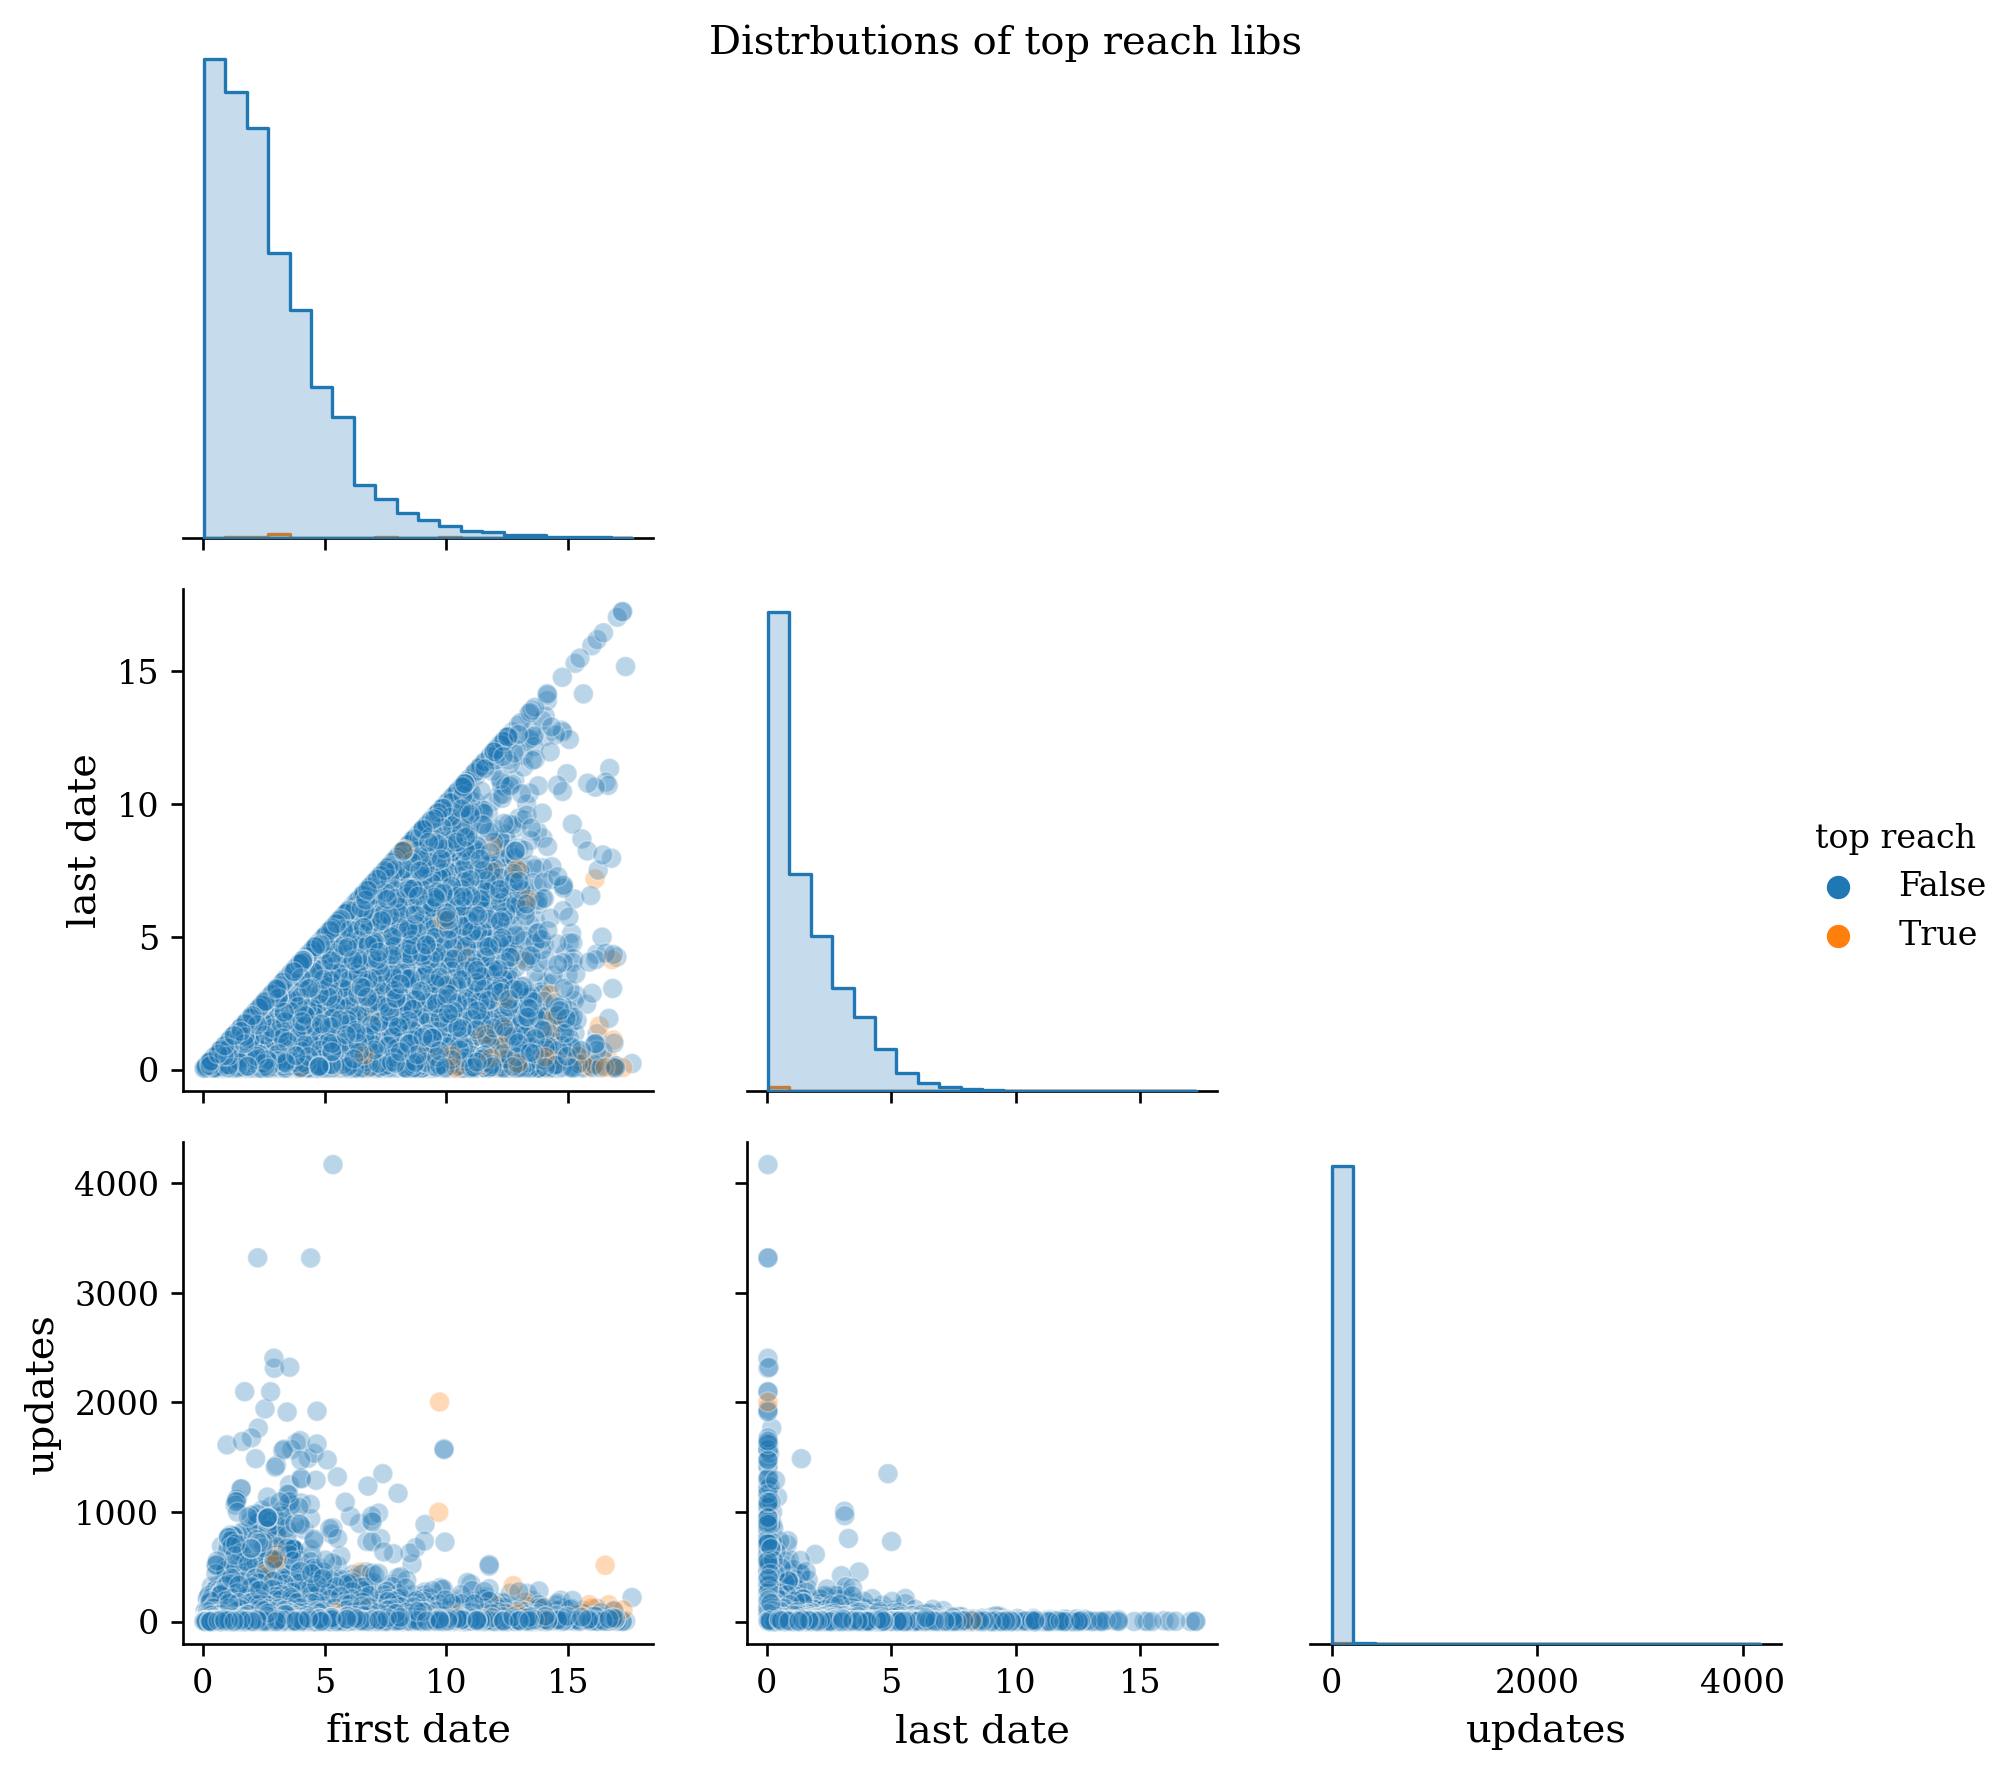

In [9]:
def sns_loghist(data, bins=20, **kwargs):
    return sns.histplot(data, bins=np.geomspace(np.min(data[kwargs["x"]])/2,
                                                2*np.max(data[kwargs["x"]]),
                                                bins),
                        **kwargs)

pg = sns.PairGrid(data=data_df, diag_sharey=False, corner=True,
                  vars=["first date", "last date", "updates"],
                  hue="top reach", hue_order=[False, True])
# pg.map_diag(sns_loghist, element="step", multiple="layer", bins=10,)
pg.map_diag(sns.histplot, element="step", bins=20)
pg.map_lower(sns.scatterplot, alpha=0.3)
# pg.set(yscale="log", xscale="log")
pg.figure.suptitle("Distrbutions of top reach libs")
pg.add_legend()
plt.show()

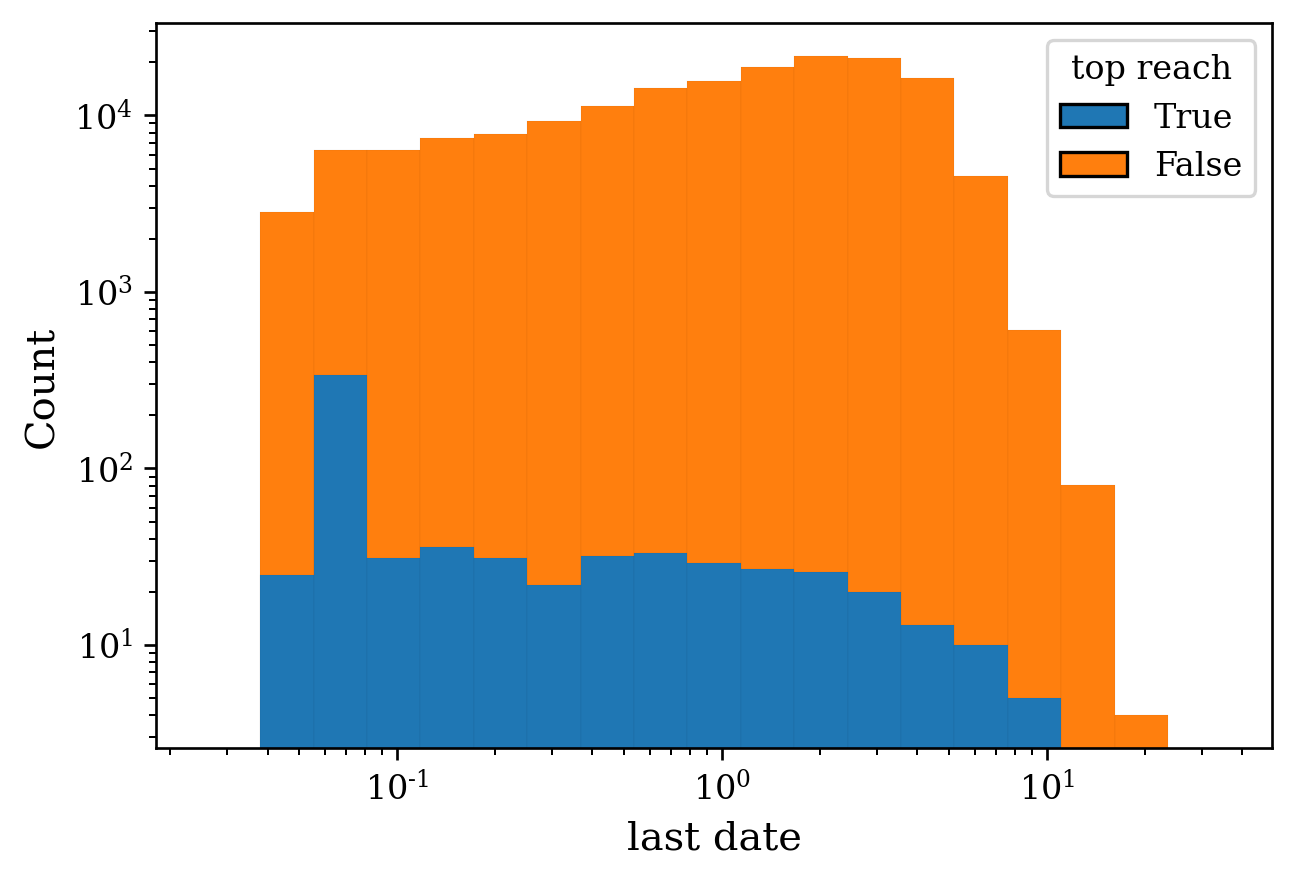

In [10]:
sns_loghist(data_df, x="last date", hue="top reach",
             multiple="layer", hue_order=[True, False], alpha=1,)
plt.yscale("log")
plt.xscale("log")

plt.show()

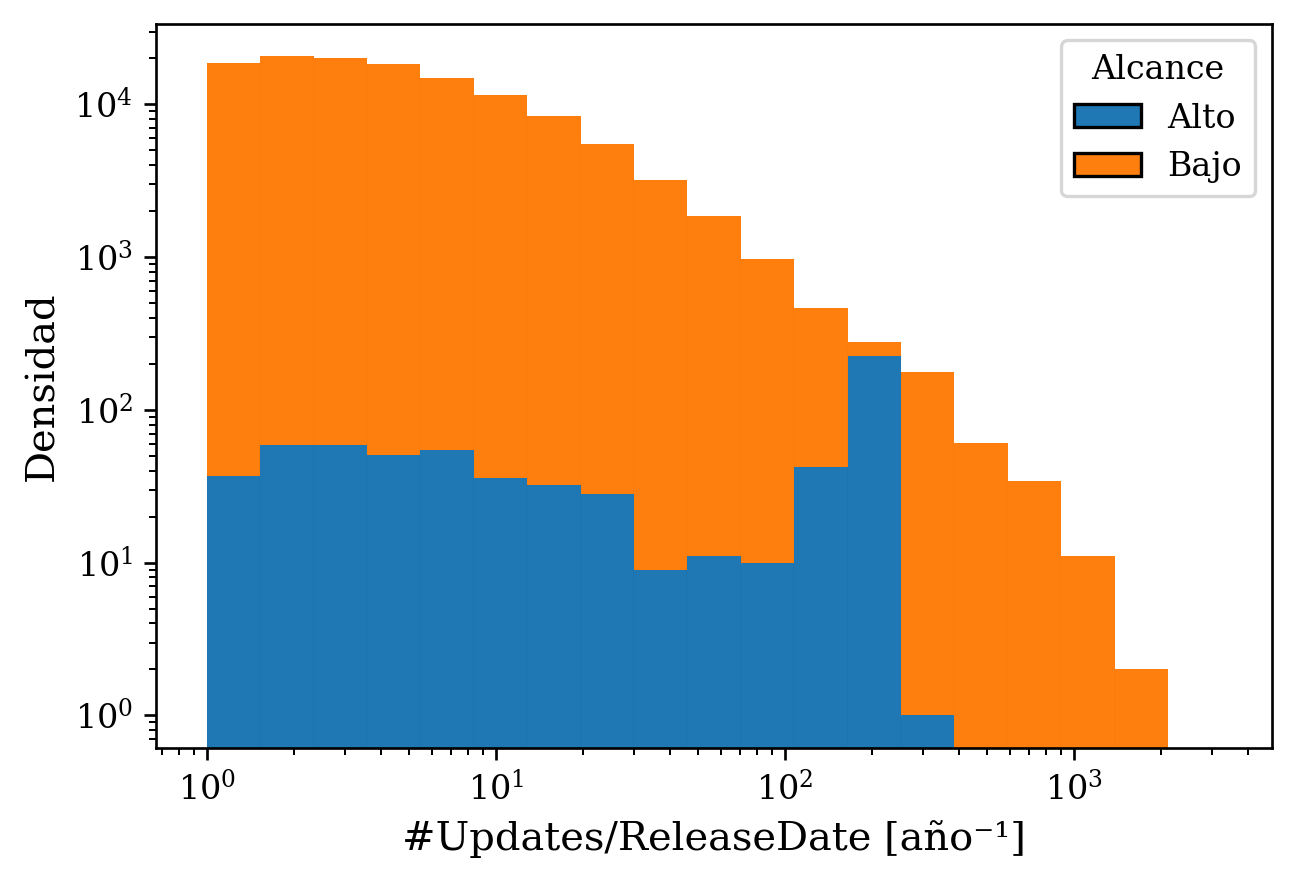

In [35]:
# var_vals = data_df["updates"]/data_df["first date"]
data_df["freq"] = data_df["updates"]/data_df["first date"]

# _, bin_edges = np.histogram(var_vals.fillna(0), )
bin_edges = np.geomspace(1, 2*data_df["freq"].max(), 20)
sns.histplot(data_df, x="freq", hue="Alcance", bins=bin_edges,
             element="bars", stat="count", hue_order=["Alto", "Bajo"],
             alpha=1)
# sns.histplot(data_df["freq"][data_df["Alcance"] == "Bajo"], bins=bin_edges,
#              element="step", alpha=0.5, stat="density", label="Bajo Alcance")
# sns.histplot(data_df["freq"][data_df["Alcance"] == "Alto"], bins=bin_edges,
#              color="C1",
#              element="step", alpha=0.5, stat="density", label="Alto Alcance")
# plt.legend(title="Alcance")
plt.yscale("log")
plt.xscale("log")
# plt.xlabel(r"$\langle f_\mathrm{updates} \rangle$ [año⁻¹]")
plt.xlabel("#Updates/ReleaseDate [año⁻¹]")
plt.ylabel("Densidad")
plt.show()

In [76]:
top_reach_df.sort_values("reach", ascending=False).head(50)

,first date,last date,updates,reach,log10 reach,first date [years ago],last date [years ago]
numpy,5828.0,34.0,126.0,138769.0,5.142292,15.0,0.0
typing-extensions,1885.0,40.0,19.0,136502.0,5.135139,5.0,0.0
six,4522.0,559.0,28.0,135902.0,5.133226,12.0,1.0
pyyaml,NaN,NaN,NaN,135573.0,5.132173,NaN,NaN
pytz,6297.0,28.0,107.0,135040.0,5.130462,17.0,0.0
markupsafe,NaN,NaN,NaN,134818.0,5.129748,NaN,NaN
babel,NaN,NaN,NaN,134781.0,5.129629,NaN,NaN
jinja2,NaN,NaN,NaN,134750.0,5.129529,NaN,NaN
python-dateutil,5214.0,489.0,32.0,134593.0,5.129022,14.0,1.0
colorama,4593.0,21.0,46.0,134428.0,5.128490,12.0,0.0


## Gráficos Charla:

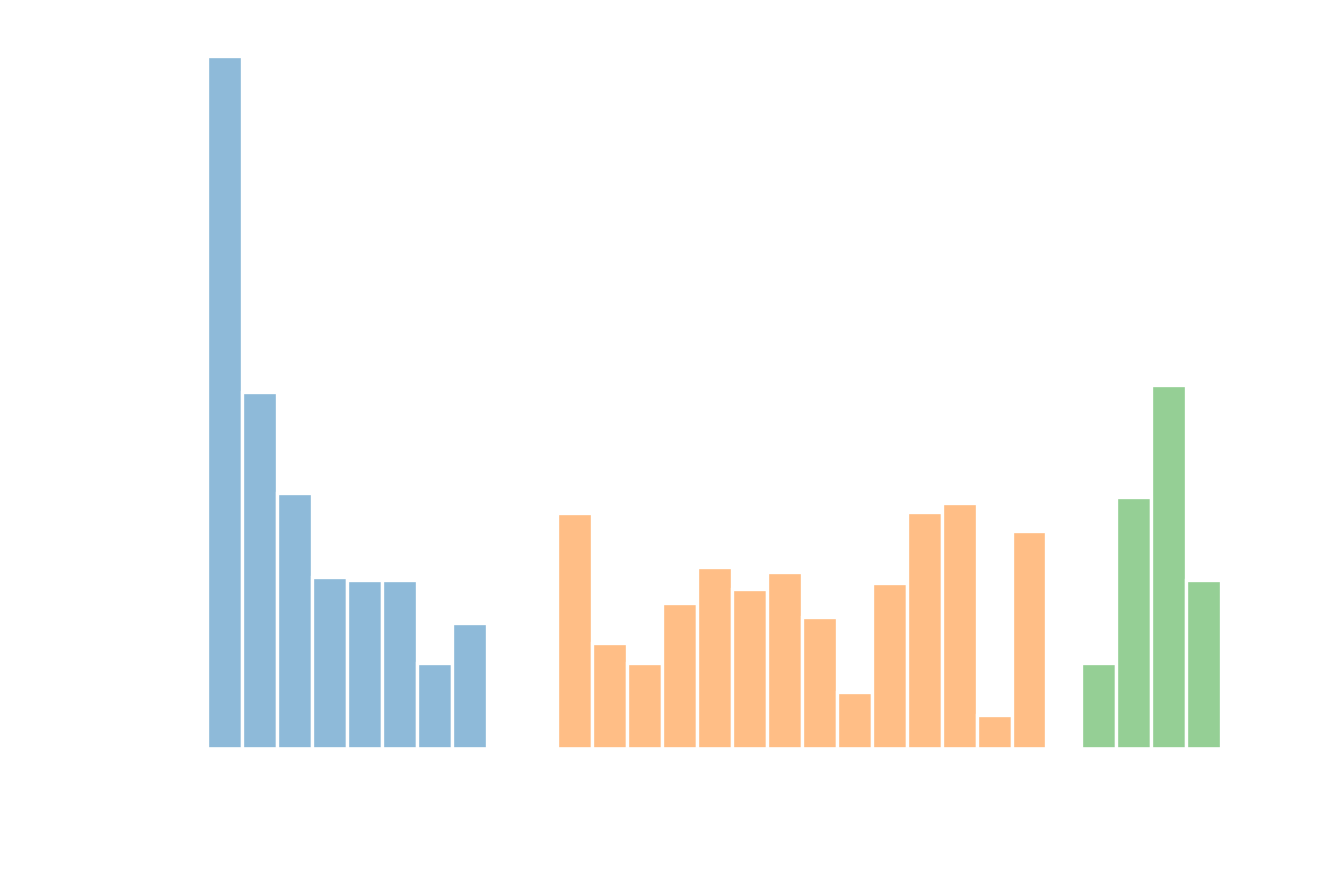

In [23]:
# bins = np.geomspace(1, 2*data_df["reach"].max(), 30)
bins = np.linspace(1, data_df["reach"].max(), 30)
with plt.rc_context({
    'text.color': "w",
    'axes.labelcolor': "w",
    'xtick.color': "w",
    'ytick.color': "w",
    }):
    fig, ax = plt.subplots(1, 1)
    ax.patch.set_alpha(0)
    for spine in ax.spines.values():
        spine.set_edgecolor('w')
    sns.histplot(data_df, x="reach", hue="Alcance",
                 bins=bins, edgecolor="w", color="r", ax=ax,
                 legend=False)
    # ax.xscale("log")
    ax.set_yscale("log")
    ax.set_ylabel("Observaciones")
    ax.set_xlabel("Alcance")
    plt.show()

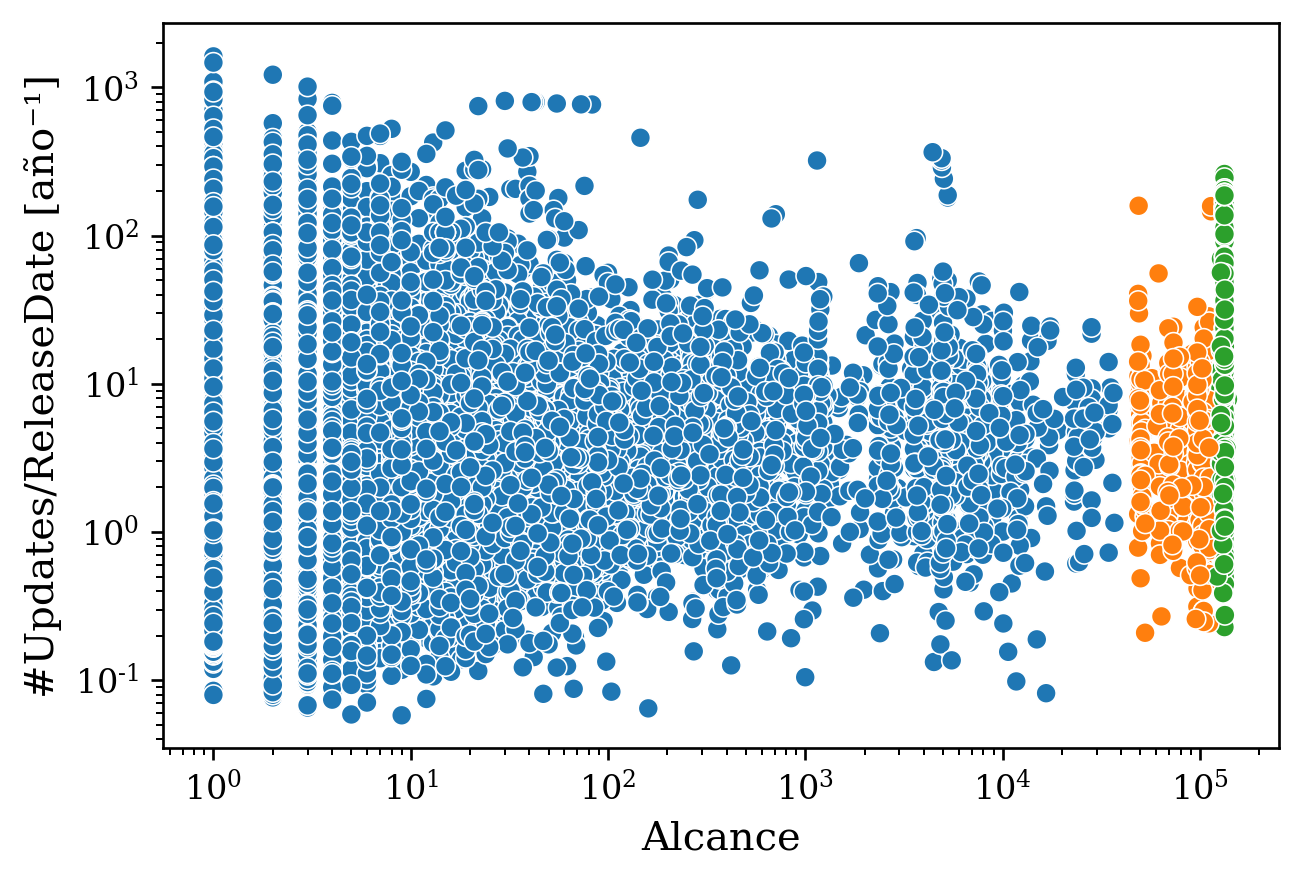

In [35]:
data_df["freq"] = data_df["updates"]/data_df["first date"]


fig, ax = plt.subplots(1, 1, )
xbins = np.geomspace(1, 1.2*max(data_df["reach"]), 30)
ybins = np.geomspace(0.8*min(data_df["freq"]), 1.2*max(data_df["freq"]), 50)
sns.scatterplot(data=data_df, x="reach", y="freq", #bins=(xbins, ybins),
             ax=ax,# cbar=True, thresh=None,
            #  hue_norm=lambda c: np.log10(c+1)/np.log10(8e3)
            hue="Alcance", legend=False)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Alcance")
ax.set_ylabel("#Updates/ReleaseDate [año⁻¹]")

plt.show()

/home/agus/mambaforge/envs/facu39/lib/python3.9/site-packages/seaborn/_statistics.py:369: RuntimeWarning: invalid value encountered in true_divide
  hist = hist.astype(float) / hist.sum()


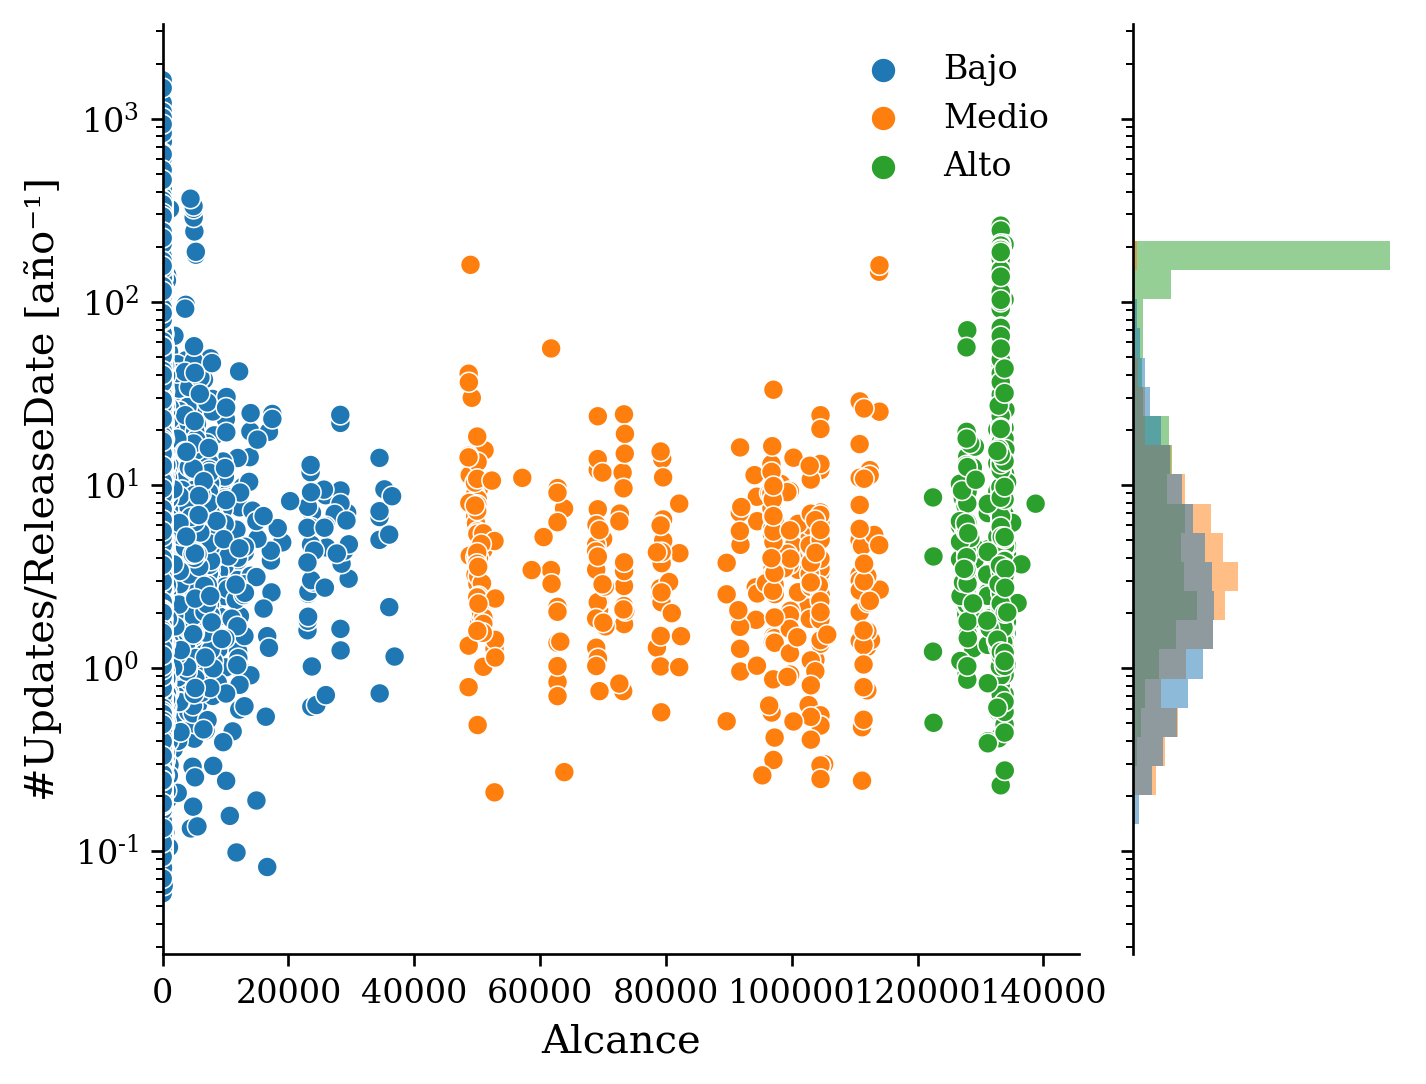

In [52]:
jg = sns.JointGrid(x=data_df["reach"], y=data_df["freq"], hue=data_df["Alcance"],
                   ratio=3,)
jg.plot_joint(sns.scatterplot, )
jg.ax_marg_x.set_visible(False)
jg.plot_marginals(sns.histplot,
                  bins=np.geomspace(0.8*data_df["freq"].min(),
                                    1.2*data_df["freq"].max(), 30),
                  stat="probability", common_norm=False,)
ax = jg.ax_joint
ax.legend(frameon=False)
# ax.set_xscale("log")
ax.set_xlim(left=0)
ax.set_yscale("log")
ax.set_xlabel("Alcance")
ax.set_ylabel("#Updates/ReleaseDate [año⁻¹]")

plt.show()

/home/agus/mambaforge/envs/facu39/lib/python3.9/site-packages/seaborn/_statistics.py:369: RuntimeWarning: invalid value encountered in true_divide
  hist = hist.astype(float) / hist.sum()


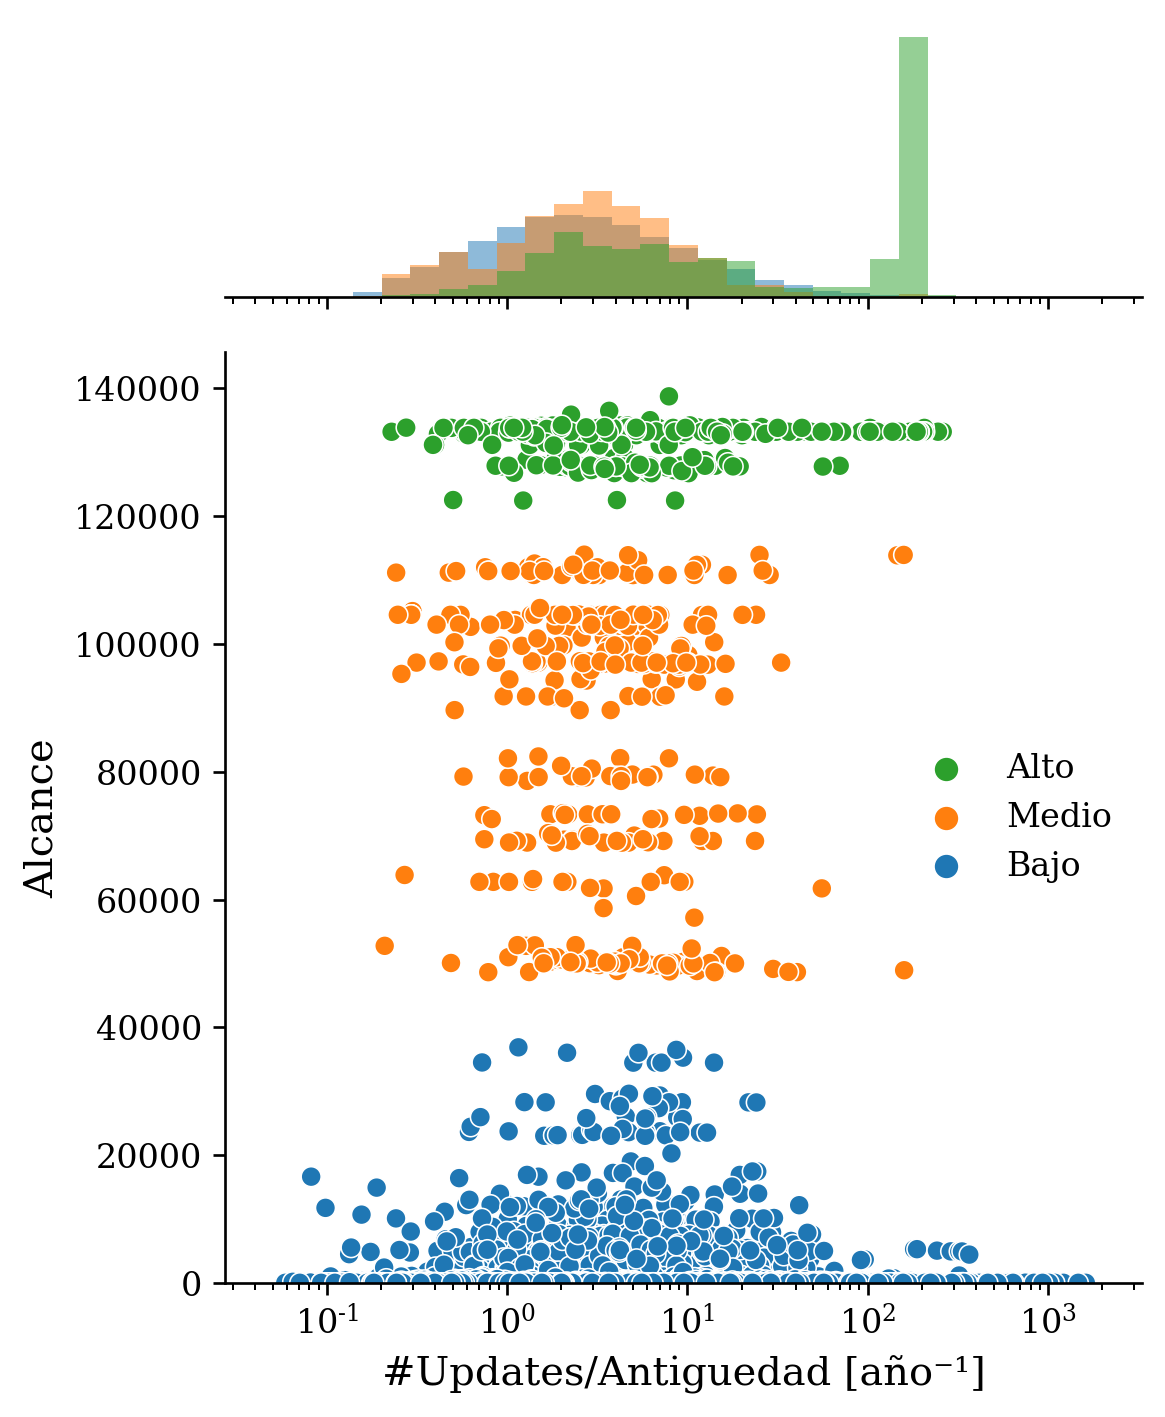

In [56]:
jg = sns.JointGrid(y=data_df["reach"], x=data_df["freq"],
                   hue=data_df["Alcance"], hue_order=["Alto", "Medio", "Bajo"],
                   palette=["C2", "C1", "C0"],
                   ratio=3,)
jg.plot_joint(sns.scatterplot, )
jg.ax_marg_y.set_visible(False)
jg.plot_marginals(sns.histplot,
                  bins=np.geomspace(0.8*data_df["freq"].min(),
                                    1.2*data_df["freq"].max(), 30),
                  stat="probability", common_norm=False,)
ax = jg.ax_joint
ax.legend(frameon=False)
# ax.set_yscale("log")
ax.set_ylim(bottom=0)
ax.set_xscale("log")
ax.set_ylabel("Alcance")
ax.set_xlabel("#Updates/Antiguedad [año⁻¹]")

plt.show()

In [59]:
data_df[(data_df["freq"] > 1.5e2) & (data_df["reach"] > 12e4)]

,first date,last date,updates,reach,k_out,k_in,Alcance,freq
boto3-stubs,3.019178,0.052055,787.0,133223.0,64.0,321.0,Alto,260.666969
botocore-stubs,1.435616,0.052055,352.0,133230.0,11.0,1.0,Alto,245.190840
moto,9.723288,0.054795,2003.0,133832.0,191.0,28.0,Alto,206.000282
mypy-boto3-accessanalyzer,2.947945,0.057534,550.0,133225.0,3.0,1.0,Alto,186.570632
mypy-boto3-acm-pca,3.021918,0.060274,568.0,133225.0,2.0,1.0,Alto,187.960109
...,...,...,...,...,...,...,...,...
mypy-boto3-worklink,3.021918,0.060274,565.0,133225.0,2.0,1.0,Alto,186.967362
mypy-boto3-workmail,3.021918,0.060274,567.0,133225.0,2.0,1.0,Alto,187.629193
mypy-boto3-workmailmessageflow,3.021918,0.060274,564.0,133225.0,2.0,1.0,Alto,186.636446
mypy-boto3-workspaces,3.021918,0.057534,580.0,133225.0,2.0,1.0,Alto,191.931097


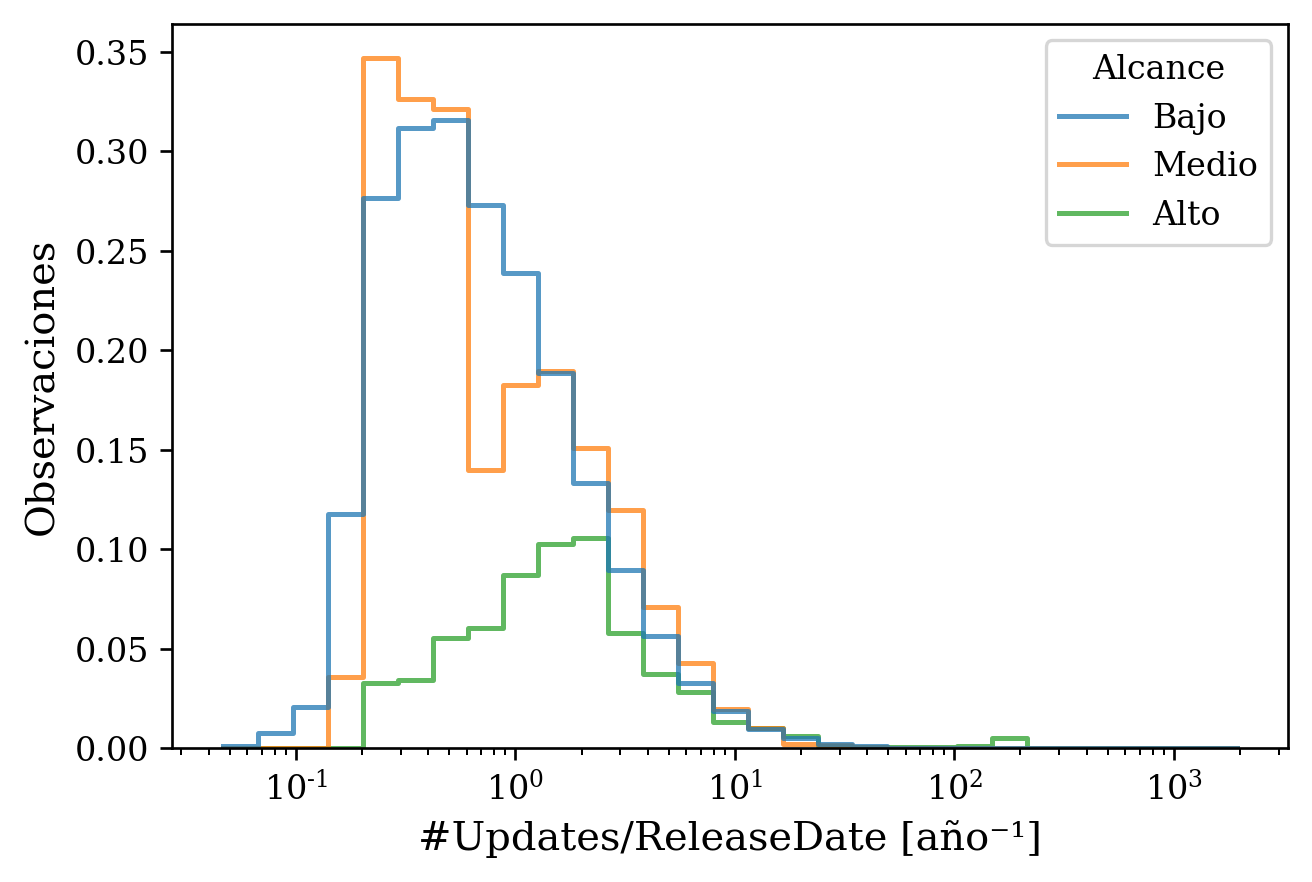

In [41]:


bin_edges = np.geomspace(0.8*data_df["freq"].min(), 1.2*data_df["freq"].max(), 30)
# bin_edges = np.linspace(data_df["freq"].min(), data_df["freq"].min(), 20)
sns.histplot(data_df, x="freq", hue="Alcance", bins=bin_edges,
             element="step", stat="density", fill=False,
             alpha=0.75, common_norm=False)

# plt.legend(title="Alcance")
# plt.yscale("log")
plt.xscale("log")
# plt.xlabel(r"$\langle f_\mathrm{updates} \rangle$ [año⁻¹]")
plt.xlabel("#Updates/ReleaseDate [año⁻¹]")
plt.ylabel("Observaciones")
plt.show()